In [1]:
import pandas as pd
import numpy as np
import re
import string

from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, roc_curve
from imblearn.over_sampling import SMOTE

import joblib

import matplotlib.pyplot as plt
import seaborn as sns

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
file_path = 'SMS Spam Dataset/spam.csv'
data = pd.read_csv(file_path, encoding='latin-1')

In [5]:
data = data[['v1', 'v2']]
data.columns = ['Label', 'text']

In [7]:
data

,Label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [9]:
data['Label'] = data['Label'].map({'ham':0, 'spam':1})

C:\Users\Asus\AppData\Local\Temp\ipykernel_23936\1571509274.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Label'] = data['Label'].map({'ham':0, 'spam':1})


In [11]:
data

,Label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...
5568,0,Will Ì_ b going to esplanade fr home?
5569,0,"Pity, * was in mood for that. So...any other s..."
5570,0,The guy did some bitching but I acted like i'd...


In [13]:
data['Label'].value_counts()

Label
0    4825
1     747
Name: count, dtype: int64

In [15]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [17]:
def preprocess_text_advanced(text):
    text = text.lower()  
    text = re.sub(r'\d+', '', text)  
    text = text.translate(str.maketrans('', '', string.punctuation))  # حذف علائم نگارشی
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])  # لماتیزاسیون
    return text

In [19]:
data['text'] = data['text'].apply(preprocess_text_advanced)

In [21]:
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1, 2))

In [23]:
# X, y
X = data['text']
y = data['Label']

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [51]:
# model
# creat
knn = KNeighborsClassifier(n_neighbors=3)

In [53]:
# fit
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [55]:
y_pred = knn.predict(X_test)

In [57]:
ac = accuracy_score(y_test, y_pred)

In [59]:
error = 1- ac
error

0.07085201793721974

In [61]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96       965
           1       1.00      0.47      0.64       150

    accuracy                           0.93      1115
   macro avg       0.96      0.74      0.80      1115
weighted avg       0.93      0.93      0.92      1115



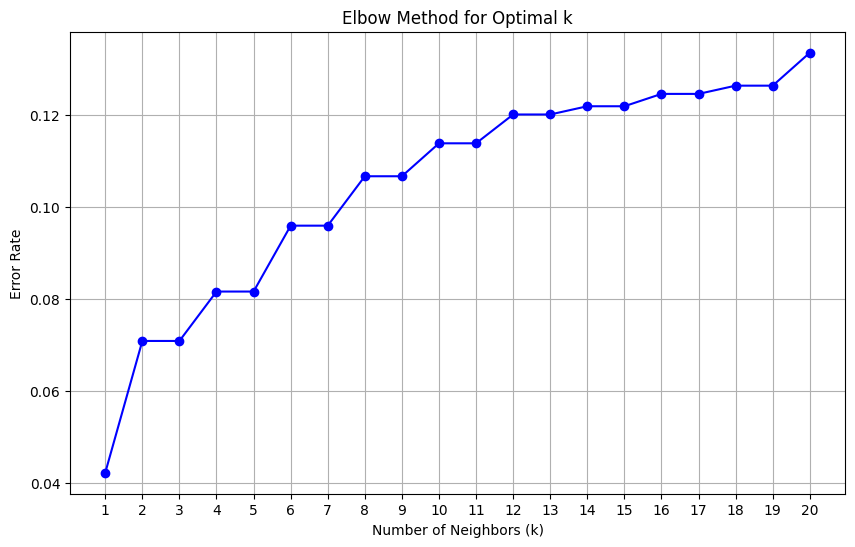

In [43]:
k_values = range(1, 21)
errors = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    error = 1 - accuracy_score(y_test, y_pred)
    errors.append(error)


plt.figure(figsize=(10, 6))
plt.plot(k_values, errors, marker='o', linestyle='-', color='b')
plt.xticks(k_values)
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Error Rate')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

In [45]:
param_grid = {'n_neighbors': range(1, 21)}
knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(1, 21)}, scoring='accuracy')

In [47]:
grid_search.best_params_

{'n_neighbors': 1}

In [49]:
knn_w = KNeighborsClassifier(n_neighbors=3, weights='distance')
knn_w.fit(X_train, y_train)
y_pred_w = knn_w.predict(X_test)
print(classification_report(y_test, y_pred_w))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97       965
           1       1.00      0.63      0.77       150

    accuracy                           0.95      1115
   macro avg       0.97      0.81      0.87      1115
weighted avg       0.95      0.95      0.94      1115

